In [1]:
# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran

# Analysis
import geopandas as gpd
import pysal
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed
from shapely.geometry import Polygon
from pysal.model import spreg

import numpy as np
import h5py      
import pandas as pd

import random
random.seed(123)
np.random.seed(123)

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 12})

/home2/faculty/ptomaszewska/miniconda3/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/home2/faculty/ptomaszewska/miniconda3/lib/python3.8/site-packages/splot/_viz_esda_mpl.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS 

## Constants

In [11]:
PATH_save_plots='./regression_results_plots/'
image='test_001'
PATH_patch_coordinates= f"../CAMELYON16_features_256_swinv2_base_patch4_window8_256_v2/all/h5_files/{image}.h5"
PATH_attention_scores= "./heatmaps/heatmap_raw_results/"\
   "CAMELYON16_256_swinv2_base_patch4_window8_256_weighted_50_0.005_0.0_sgd_0.7_False_0.25_10_50_True_512_128/0/"\
   f"1/{image}/{image}_blockmap.h5"
patch_size=256

# Data loading and preparation

In [13]:
coords_att=h5py.File(PATH_attention_scores, 'r') 
att=coords_att['attention_scores'][:]

coords=coords_att['coords'][:]

d=np.concatenate((coords, att), axis=1) 

df_a=pd.DataFrame(d, columns=['x', 'y', 'att'])

coords_feat=h5py.File(PATH_patch_coordinates, 'r')

coords_f=att=coords_feat['coords'][:]
features=att=coords_feat['features'][:]
d_f=np.concatenate((coords_f, features), axis=1) 

n_features=features.shape[1]
    
names_feat=list(range(0,n_features))
names_feat=[str(i)+"_feat" for i in names_feat]
df_f=pd.DataFrame(d_f, columns=['x', 'y']+names_feat)

df=pd.merge(df_a, df_f, on=['x', 'y'])

In [14]:
c=df.iloc[:,2:].corr() # correlation without x,y patch positions

In [15]:
c_abs=c.abs()

# Select upper triangle of correlation matrix
upper = c.where(np.triu(np.ones(c.shape), k=1).astype(bool))

# Find features with correlation greater than threshold
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]  

# Drop features 
df.drop(to_drop, axis=1, inplace=True)

## Conversion to a spatial data type

In [16]:
polys=[]

for x, y in zip(df.x, df.y):
   poly = Polygon([(x, y), (x + patch_size, y), (x + patch_size, y + patch_size), (x, y + patch_size)])
   polys.append(poly)

polys = gpd.GeoSeries(polys)

df['geometry']=polys
gdf = gpd.GeoDataFrame(df)

## Spatial weights matrix

In [17]:
k=24
w = weights.KNN.from_dataframe(gdf, k=k)
w.transform = "R"

# OLS regression

In [24]:
variable_names=gdf.columns.tolist()
variable_names=variable_names[3:-1]  # to omit information about x,y,att and geometry
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    gdf['att'].values,            
    # Independent variables
    gdf[variable_names].values,
    # Dependent variable name
    name_y="att",
    # Independent variable name
    name_x=variable_names,
    moran=True,
    spat_diag=True,
    w=w ,                         
    white_test=True,
    vm=True
)

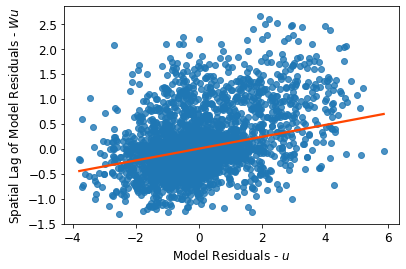

In [25]:
lag_residual = weights.spatial_lag.lag_spatial(w, m1.u)
ax = seaborn.regplot(
    x=m1.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model Residuals - $W u$");

# LISA

In [26]:
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, w, permutations=9999)

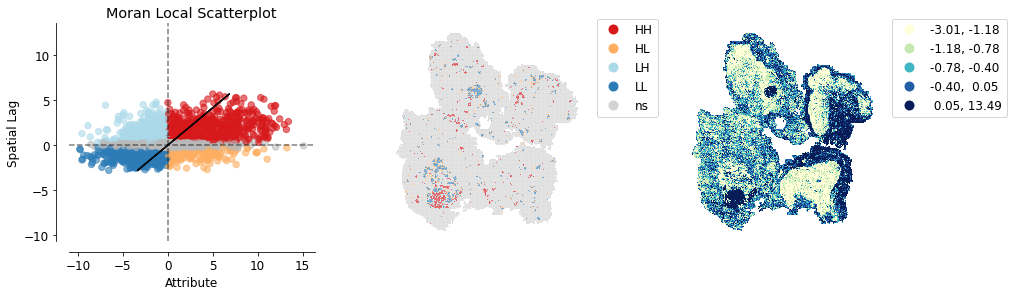

In [27]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(outliers, gdf, 'att');

plt.savefig(PATH_save_plots+'LISA.png',  dpi=300, bbox_inches='tight')